In [596]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import drive
import pickle
from nltk.tokenize import sent_tokenize, word_tokenize

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
options = { 'node_color': 'black','node_size': 100,'width': 3}

In [0]:
#Translate sentence to a Scene
class Scene():
  #Each sentece is a temporal evolution of graphs
  def __init__(self):
    self.node_list = []
    self.relationList = []
    self.sceneGraph = nx.DiGraph()
    self.temporalListofGraphs = []
    self.timeAlive = 0 #No concept of time (yet)
  
  def addNode(self, node):
    print("Debug: added node: ", node)
    self.node_list.append(node)
    self.sceneGraph.add_node(node)
    
  def addEdgeAttributeName(self, attr, f, t):
    print("Added edge between", f, " and ", t, " with  attr: ", attr)
    self.sceneGraph.add_edge(f,t)
    self.relationList.append([f,t,attr])
    
  def drawGraphatTime(self, time):
    print(self.temporalListofGraphs)
    pos = nx.shell_layout(self.temporalListofGraphs[time]);
    nx.draw_random(self.temporalListofGraphs[time], with_labels=True)
    
  def drawCurrentGraph(self):
    pos = nx.shell_layout(self.temporalListofGraphs[self.timeAlive-1])
    nx.draw_random(self.temporalListofGraphs[self.timeAlive-1], with_labels=True)
    
  def captureMoment(self):
    #NOTE: Only incriment time here and no where else 
    self.temporalListofGraphs.append(self.sceneGraph.copy())
    self.timeAlive = self.timeAlive + 1
    

In [0]:
class Concept():
  #Each concept has a name and a series of ActionMemories
  def __init__(self, cName, a, f, t, attrib):
    self.conceptName = cName
    self.word_list = []
    self.action = a
    self.connectThis = f
    self.connectTo = t
    self.attribName = attrib
    
  def addWordToConcept(self, w):
    self.word_list.append(w)


In [0]:
class Mind():
  #Mind is the object that is saved and restored so contain state-less
  #information here
  def __init__(self):
    self.listOfConcepts = []
  
  def addConcept(self, c):
    self.listOfConcepts.append(c)

class Jasmine():
  def __init__(self):
    #Recover memory
    self.mind = Mind()
    self.retriveMemories()
    self.mainScene = Scene()
    
  def resetMemory(self):
    self.mind = Mind()
    
  def saveMemories(self):
    with open('/content/gdrive/My Drive/memoryState.obj', 'wb') as file:
      pickle.dump(self.mind, file)
      
  def retriveMemories(self):
    with open('/content/gdrive/My Drive/memoryState.obj', 'rb') as file:
      self.mind = pickle.load(file)
      
  def readUserInput(self):
    currentInput = input("You: ")
    #Check if question or scene (./?)
    print("User input ends with: ", currentInput.endswith('.'))
    if currentInput.endswith('.'):
      self.parseSentence2Scene(currentInput)
  
  def sayThis(self, str):
    print("Jasmine: ", str)
    
  def askThis(self, str):
    self.sayThis(str)
    return input("You: ")
    
  def executeThis(self, concept, instanceName):
    if concept.action == "add node":
      self.mainScene.addNode(instanceName)
    elif concept.action == "add edge":
      self.mainScene.addEdgeAttributeName(concept.attribName, concept.connectThis, concept.connectTo)
    self.mainScene.captureMoment()
    
  def word2Concept(self, w):
    for concept in self.mind.listOfConcepts:
      for word in concept.word_list:
        if word == w:
          return concept
    print("Failed look up for: ", w)
    return None
    
  def createSpecficConceptInstance(self, con, wordList):
    #Search the concept stored in connectThis in
    lookingFor = con.connectThis
    print("LookingForSpecficInstanceOf: ", lookingFor, con.conceptName)
    for word in wordList:
      x = self.word2Concept(word) 
      if x is not None:
        if x.conceptName == lookingFor:
          conF = word
    lookingFor = con.connectTo
    for word in wordList:
      x = self.word2Concept(word) 
      if x is not None:
        if x.conceptName == lookingFor:
          conT = word
    return Concept(con.conceptName, con.action, conF, conT, con.attribName)
        
          
    
  def parseSentence2Scene(self,currentInput):
    found = 0
    words = [word for word in word_tokenize(currentInput)]
    print(words)
    for word in words:
      #Search memory using your mind 
      #if found then execute otherwise learn with human
      print("Looking for: ", word)
      found = 0
      for concept in self.mind.listOfConcepts:
        for wordSeen in concept.word_list:
          if wordSeen == word:
            #Word found in action memory 
            #execute action in the mind
            found = 1
            if(concept.action != "add edge"):
              self.executeThis(concept, word)
      if(found == 0):
        #Word not found ask human L0 question 
        self.sayThis("I don't know what " + word + " means.")
        ans = self.askThis("Can you teach me?")
        #Add to static memory systematically 
        if ans == "Yes" or ans == "yes":
          self.learnConceptWithHuman(word, words)
          
    #Now you have plotted nodes, plot edges
    for word in words:
      for concept in self.mind.listOfConcepts:
        for wordSeen in concept.word_list:
          if wordSeen == word:
            #Word found in action memory 
            #execute action in the mind
            found = 1
            if(concept.action == "add edge"):
              print("Adding edge on ", word)
              newConcept = self.createSpecficConceptInstance(concept, words)
              self.executeThis(newConcept, word)
  
  def learnConceptWithHuman(self, word, words):
    ans = self.askThis("Do I Know the Concept?")
    if ans == "Yes" or ans == "yes":
      #Search in concept memory and append word instance
      cName = self.askThis("What is the name of the concept?")
      for concept in self.mind.listOfConcepts:
        if concept.conceptName == cName:
          concept.addWordToConcept(word)
    else:
      #create a new concept 
      cName = self.askThis("What is the name of the concept?")
      act = self.askThis("What is the action I am supposed to take?")
      fName = None
      tName = None
      aName = None
      if act == "add edge":
        fName = self.askThis("What does it link?")
        tName = self.askThis("What does it link to?")
        aName = self.askThis("What is the connection?")
      con = Concept(cName, act, fName, tName, aName)
      con.addWordToConcept(word)
      self.mind.addConcept(con)
    
  def makeSelfAware(self):
    self.mainScene.add_node("Jasmine")
    self.mainScene.captureMoment()
    
    
    
    

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway

In [601]:
j = Jasmine()
#j.resetMemory()
j.readUserInput()
j.readUserInput()
j.saveMemories()


You: Mary moved to the bathroom.
User input ends with:  True
['Mary', 'moved', 'to', 'the', 'bathroom', '.']
Looking for:  Mary
Debug: added node:  Mary
Looking for:  moved
Looking for:  to
Jasmine:  I don't know what to means.
Jasmine:  Can you teach me?
You: no
Looking for:  the
Jasmine:  I don't know what the means.
Jasmine:  Can you teach me?
You: no
Looking for:  bathroom
Debug: added node:  bathroom
Looking for:  .
Jasmine:  I don't know what . means.
Jasmine:  Can you teach me?
You: no
Adding edge on  moved
LookingForSpecficInstanceOf:  Person ChangeInLocation
Failed look up for:  to
Failed look up for:  the
Failed look up for:  .
Failed look up for:  to
Failed look up for:  the
Failed look up for:  .
Added edge between Mary  and  bathroom  with  attr:  location
You: John went to the hallway.
User input ends with:  True
['John', 'went', 'to', 'the', 'hallway', '.']
Looking for:  John
Debug: added node:  John
Looking for:  went
Looking for:  to
Jasmine:  I don't know what to mean

Nodes:  ['Mary', 'bathroom', 'John', 'hallway']
[<networkx.classes.digraph.DiGraph object at 0x7f1f917f7128>, <networkx.classes.digraph.DiGraph object at 0x7f1f917f7c18>, <networkx.classes.digraph.DiGraph object at 0x7f1f917f7160>, <networkx.classes.digraph.DiGraph object at 0x7f1f917f7358>, <networkx.classes.digraph.DiGraph object at 0x7f1f917f7080>, <networkx.classes.digraph.DiGraph object at 0x7f1f917f7550>]


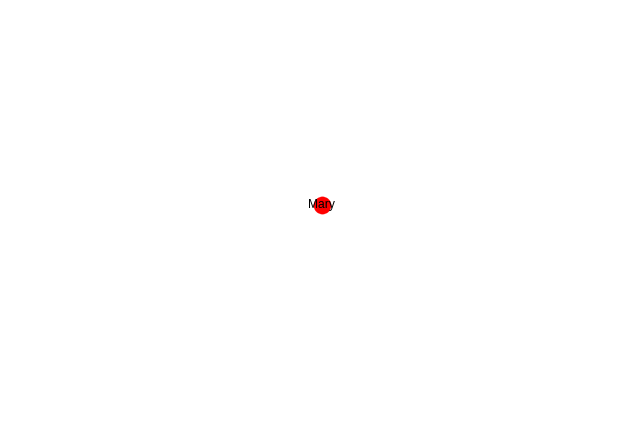

In [602]:
print("Nodes: ", j.mainScene.sceneGraph.nodes)
j.mainScene.drawGraphatTime(0)

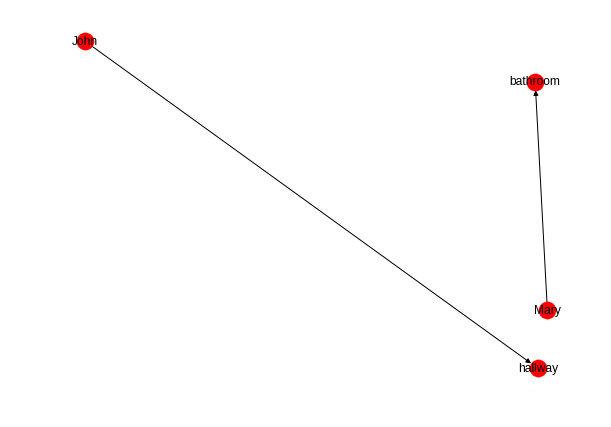

In [603]:
j.mainScene.drawCurrentGraph()